In [1]:
import torch
import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns

from einops import rearrange
from pathlib import Path

from hydra import initialize, compose
from hydra.utils import instantiate
import pytorch_lightning
from pytorch_lightning.utilities import move_data_to_device

from bliss.catalog import TileCatalog, convert_flux_to_magnitude
from bliss.cached_dataset import CachedSimulatedDataModule
from case_studies.dc2_mdt.utils.rml_encoder import M2MDTRMLEncoder

In [2]:
model_name = "great_lake_exp_04-25-1"
model_check_point_name = "encoder_161.ckpt"
model_path = f"../../../bliss_output/{model_name}_m2_mdt_rml_{model_check_point_name}"
cached_data_path =  Path("/data/scratch/pduan/posterior_cached_files")
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
with initialize(config_path="./m2_mdt_config", version_base=None):
    cfg = compose("m2_mdt_rml_train_config")

In [3]:
seed = cfg.train.seed
pytorch_lightning.seed_everything(seed=seed)

Seed set to 7272


7272

In [4]:
batch_size = 800
m2: CachedSimulatedDataModule = instantiate(cfg.cached_simulator)
m2.batch_size = batch_size
m2.setup(stage="validate")
m2_val_dataloader = m2.val_dataloader()

In [5]:
my_encoder: M2MDTRMLEncoder = instantiate(cfg.encoder).to(device=device)
pretrained_weights = torch.load(model_path, map_location=device)["state_dict"]
my_encoder.load_state_dict(pretrained_weights)
my_encoder.eval();

ddim_sampling_steps = 3
ddim_eta = 0.0
my_encoder.reconfig_sampling(new_sampling_time_steps=ddim_sampling_steps, new_ddim_eta=ddim_eta)

In [6]:
cached_file_name = f"m2_mdt_rml_posterior_" \
                        f"{model_name}_{model_check_point_name}_" \
                        f"ddim_steps_{ddim_sampling_steps}_" \
                        f"eta_{ddim_eta:.1f}_" \
                        f"seed_{seed}.pt"
save_path = cached_data_path / cached_file_name
if not os.path.isfile(save_path):
    print(f"can't find cached file [{cached_file_name}]; rerun the inference")
    diffusion_result_dict = {
        "pred_n_sources_list": [],
        "pred_locs_list": [],
        "pred_fluxes_list": [],
        "target1_n_sources_list": [],
        "target1_locs_list": [],
        "target1_fluxes_list": [],
        "target2_n_sources_list": [],
        "target2_locs_list": [],
        "target2_fluxes_list": [],
    }

    for one_batch in tqdm.tqdm(m2_val_dataloader):
        one_batch = move_data_to_device(one_batch, device=device)

        target_tile_cat = TileCatalog(one_batch["tile_catalog"])
        target_cat1 = target_tile_cat.get_brightest_sources_per_tile(
            band=0, exclude_num=0
        )
        target_cat2 = target_tile_cat.get_brightest_sources_per_tile(
            band=0, exclude_num=1
        )
        diffusion_result_dict["target1_n_sources_list"].append(target_cat1["n_sources"].cpu())
        diffusion_result_dict["target1_locs_list"].append(target_cat1["locs"].cpu())
        diffusion_result_dict["target1_fluxes_list"].append(target_cat1["fluxes"].cpu())
        diffusion_result_dict["target2_n_sources_list"].append(target_cat2["n_sources"].cpu())
        diffusion_result_dict["target2_locs_list"].append(target_cat2["locs"].cpu())
        diffusion_result_dict["target2_fluxes_list"].append(target_cat2["fluxes"].cpu())

        with torch.inference_mode():
            sample_tile_cat = my_encoder.sample(one_batch)

        diffusion_result_dict["pred_n_sources_list"].append(sample_tile_cat["n_sources"].cpu())
        diffusion_result_dict["pred_locs_list"].append(sample_tile_cat["locs"].cpu())  # (b, h, w, 2, 2)
        diffusion_result_dict["pred_fluxes_list"].append(sample_tile_cat["fluxes"].cpu())  # (b, h, w, 2, 6)

    torch.save(diffusion_result_dict, save_path)
else:
    print(f"find the cached file [{cached_file_name}]; run nothing")

can't find cached file [m2_mdt_rml_posterior_great_lake_exp_04-25-1_encoder_161.ckpt_ddim_steps_3_eta_0.0_seed_7272.pt]; rerun the inference


100%|██████████| 31/31 [00:48<00:00,  1.58s/it]


In [7]:
for k, v in diffusion_result_dict.items():
    print(f"{k}[0]: {v[0].shape}")

pred_n_sources_list[0]: torch.Size([800, 20, 20])
pred_locs_list[0]: torch.Size([800, 20, 20, 2, 2])
pred_fluxes_list[0]: torch.Size([800, 20, 20, 2, 1])
target1_n_sources_list[0]: torch.Size([800, 20, 20])
target1_locs_list[0]: torch.Size([800, 20, 20, 1, 2])
target1_fluxes_list[0]: torch.Size([800, 20, 20, 1, 1])
target2_n_sources_list[0]: torch.Size([800, 20, 20])
target2_locs_list[0]: torch.Size([800, 20, 20, 1, 2])
target2_fluxes_list[0]: torch.Size([800, 20, 20, 1, 1])


In [8]:
with open(cached_data_path / "m2_bliss_posterior_exp_04-20-3_encoder_31.ckpt_whole_val_set_seed_7272.pt", "rb") as f:
    bliss_result_dict = torch.load(f, map_location="cpu")

In [9]:
for k, v in bliss_result_dict.items():
    print(f"{k}[0]: {v[0].shape}")

pred_n_sources_list[0]: torch.Size([800, 20, 20])
pred_locs_list[0]: torch.Size([800, 20, 20, 2, 2])
pred_fluxes_list[0]: torch.Size([800, 20, 20, 2, 1])
target1_n_sources_list[0]: torch.Size([800, 20, 20])
target1_locs_list[0]: torch.Size([800, 20, 20, 1, 2])
target1_fluxes_list[0]: torch.Size([800, 20, 20, 1, 1])
target2_n_sources_list[0]: torch.Size([800, 20, 20])
target2_locs_list[0]: torch.Size([800, 20, 20, 1, 2])
target2_fluxes_list[0]: torch.Size([800, 20, 20, 1, 1])


## Flux Scatter

In [10]:
diffusion_true_fluxes = []
diffusion_pred_fluxes = []
for true1_ns, true2_ns, true1_f, true2_f, pred_ns, pred_f in zip(diffusion_result_dict["target1_n_sources_list"],
                                                                    diffusion_result_dict["target2_n_sources_list"],
                                                                    diffusion_result_dict["target1_fluxes_list"],
                                                                    diffusion_result_dict["target2_fluxes_list"],
                                                                    diffusion_result_dict["pred_n_sources_list"],
                                                                    diffusion_result_dict["pred_fluxes_list"],
                                                                    strict=True):
    ns_mask = torch.stack([true1_ns > 0, true2_ns > 0], dim=-1)  # (b, h, w, 2)
    assert (pred_ns == ns_mask.sum(dim=-1)).all()
    true_f = torch.cat([true1_f, true2_f], dim=-2) 
    diffusion_pred_fluxes.append(pred_f[ns_mask].squeeze(-1))
    diffusion_true_fluxes.append(true_f[ns_mask].squeeze(-1))
diffusion_true_fluxes = torch.cat(diffusion_true_fluxes, dim=0)
diffusion_pred_fluxes = torch.cat(diffusion_pred_fluxes, dim=0)

In [11]:
diffusion_true_fluxes.shape, diffusion_pred_fluxes.shape

(torch.Size([5132500]), torch.Size([5132500]))

In [12]:
diffusion_true_fluxes.min(), diffusion_true_fluxes.max()

(tensor(0.9419), tensor(8022.7627))

In [13]:
diffusion_pred_fluxes.min(), diffusion_pred_fluxes.max()

(tensor(0.2709), tensor(10392.5771))

In [14]:
t_m = convert_flux_to_magnitude(diffusion_true_fluxes, zero_point=1e9)
print(f"min {t_m.min().item():.3f}, max {t_m.max().item():.3f}")

min 12.739, max 22.565


In [15]:
p_m = convert_flux_to_magnitude(diffusion_pred_fluxes, zero_point=1e9)
print(f"min {p_m.min().item():.3f}, max {p_m.max().item():.3f}")

min 12.458, max 23.918


In [16]:
def symmetry_deviation_wrt_45d(points: torch.Tensor, sample_n=1000, iters=100):
    min_dists_list = []
    for _ in range(iters):
        sub_points = points[torch.randperm(points.shape[0])[:sample_n], :]
        reflected_points = sub_points[:, [1, 0]]
        diff = reflected_points[:, None, :] - sub_points[None, :, :]
        dists = torch.norm(diff, dim=-1)  # (N, N)
        min_dists = dists.amin(dim=1)  # (N,)
        min_dists_list.append(min_dists.median())
    return torch.stack(min_dists_list, dim=0).median().item()

In [17]:
mag_bin_boundaries = torch.tensor([13.2392, 15.4456, 17.6521, 19.8585, 22.0650])

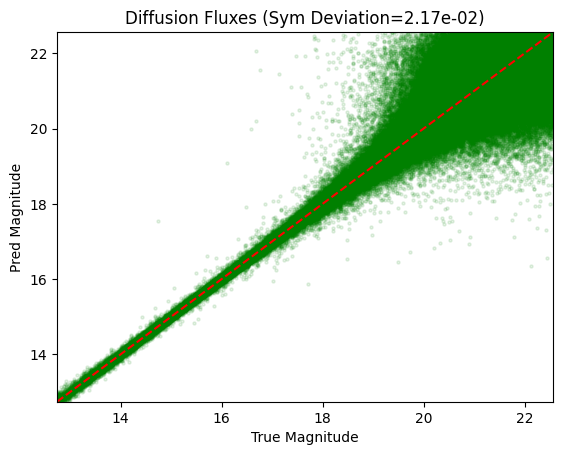

In [18]:
d_pred_m = convert_flux_to_magnitude(diffusion_pred_fluxes, zero_point=1e9)
d_true_m = convert_flux_to_magnitude(diffusion_true_fluxes, zero_point=1e9)
band_mag_mask = (d_pred_m > mag_bin_boundaries.min()) & \
                (d_pred_m < mag_bin_boundaries.max()) & \
                (d_true_m > mag_bin_boundaries.min()) & \
                (d_true_m < mag_bin_boundaries.max())
sym_dev = symmetry_deviation_wrt_45d(torch.stack([d_pred_m, d_true_m], dim=1)[band_mag_mask])
plt.scatter(d_true_m, d_pred_m, 
            s=5, c="green", alpha=0.1)
expect_pts = torch.linspace(d_true_m.min(), d_true_m.max(), 10)
plt.plot(expect_pts, expect_pts, linestyle="dashed", color="red")
plt.xlim(d_true_m.min(), d_true_m.max())
plt.ylim(d_true_m.min(), d_true_m.max())
plt.xlabel("True Magnitude")
plt.ylabel("Pred Magnitude")
plt.title(f"Diffusion Fluxes (Sym Deviation={sym_dev:.2e})")
plt.show()

In [19]:
bliss_true_fluxes = []
bliss_pred_fluxes = []
for true1_ns, true2_ns, true1_f, true2_f, pred_ns, pred_f in zip(bliss_result_dict["target1_n_sources_list"],
                                                                    bliss_result_dict["target2_n_sources_list"],
                                                                    bliss_result_dict["target1_fluxes_list"],
                                                                    bliss_result_dict["target2_fluxes_list"],
                                                                    bliss_result_dict["pred_n_sources_list"],
                                                                    bliss_result_dict["pred_fluxes_list"],
                                                                    strict=True):
    ns_mask = torch.stack([true1_ns > 0, true2_ns > 0], dim=-1)  # (b, h, w, 2)
    true_f = torch.cat([true1_f, true2_f], dim=-2) 
    bliss_pred_fluxes.append(pred_f[ns_mask].squeeze(-1))
    bliss_true_fluxes.append(true_f[ns_mask].squeeze(-1))
bliss_true_fluxes = torch.cat(bliss_true_fluxes, dim=0)
bliss_pred_fluxes = torch.cat(bliss_pred_fluxes, dim=0)

In [20]:
bliss_true_fluxes.shape, bliss_pred_fluxes.shape

(torch.Size([5132607]), torch.Size([5132607]))

In [21]:
bliss_true_fluxes.min(), bliss_true_fluxes.max()

(tensor(0.9419), tensor(8022.7627))

In [22]:
bliss_pred_fluxes.min(), bliss_pred_fluxes.max()

(tensor(0.0372), tensor(16555.9746))

In [23]:
t_m = convert_flux_to_magnitude(bliss_true_fluxes, zero_point=1e9)
print(f"min {t_m.min().item():.3f}, max {t_m.max().item():.3f}")

min 12.739, max 22.565


In [24]:
p_m = convert_flux_to_magnitude(bliss_pred_fluxes, zero_point=1e9)
print(f"min {p_m.min().item():.3f}, max {p_m.max().item():.3f}")

min 11.953, max 26.074


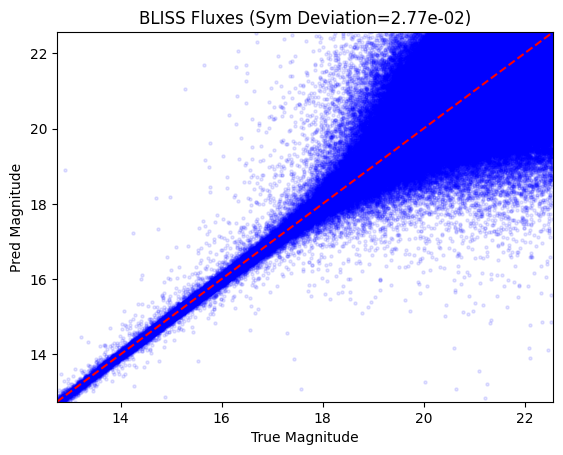

In [25]:
b_pred_m = convert_flux_to_magnitude(bliss_pred_fluxes, zero_point=1e9)
b_true_m = convert_flux_to_magnitude(bliss_true_fluxes, zero_point=1e9)
band_mag_mask = (b_pred_m > mag_bin_boundaries.min()) & \
                (b_pred_m < mag_bin_boundaries.max()) & \
                (b_true_m > mag_bin_boundaries.min()) & \
                (b_true_m < mag_bin_boundaries.max())
sym_dev = symmetry_deviation_wrt_45d(torch.stack([b_pred_m, b_true_m], dim=1)[band_mag_mask])
plt.scatter(b_true_m, b_pred_m, 
            s=5, c="blue", alpha=0.1)
expect_pts = torch.linspace(b_true_m.min(), b_true_m.max(), 10)
plt.plot(expect_pts, expect_pts, linestyle="dashed", color="red")
plt.xlim(b_true_m.min(), b_true_m.max())
plt.ylim(b_true_m.min(), b_true_m.max())
plt.xlabel("True Magnitude")
plt.ylabel("Pred Magnitude")
plt.title(f"BLISS Fluxes (Sym Deviation={sym_dev:.2e})")
plt.show()

## Flux

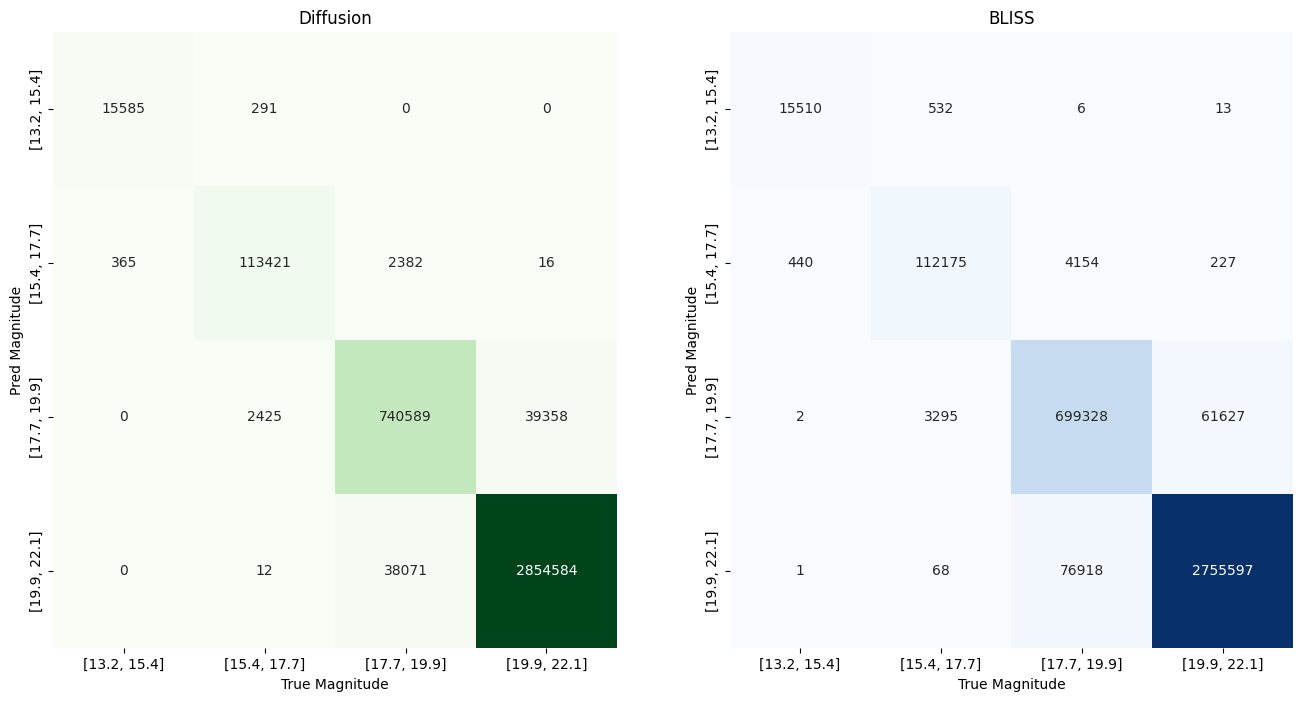

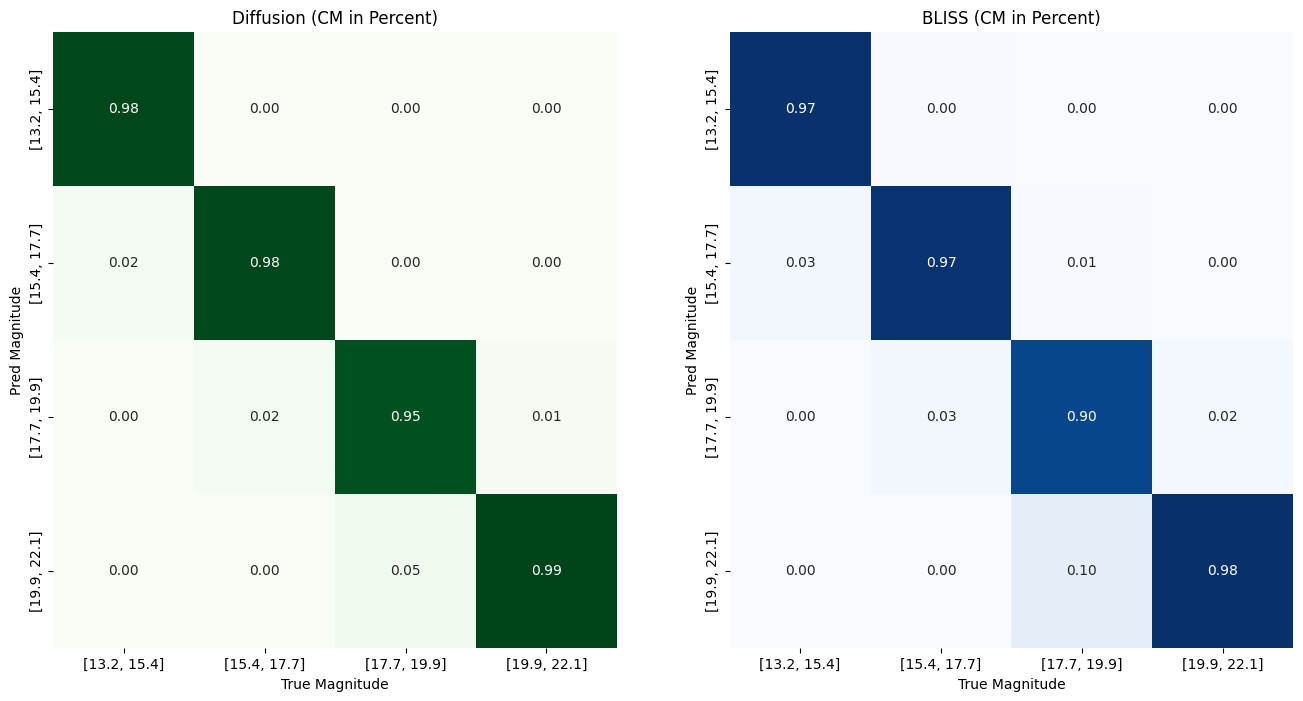

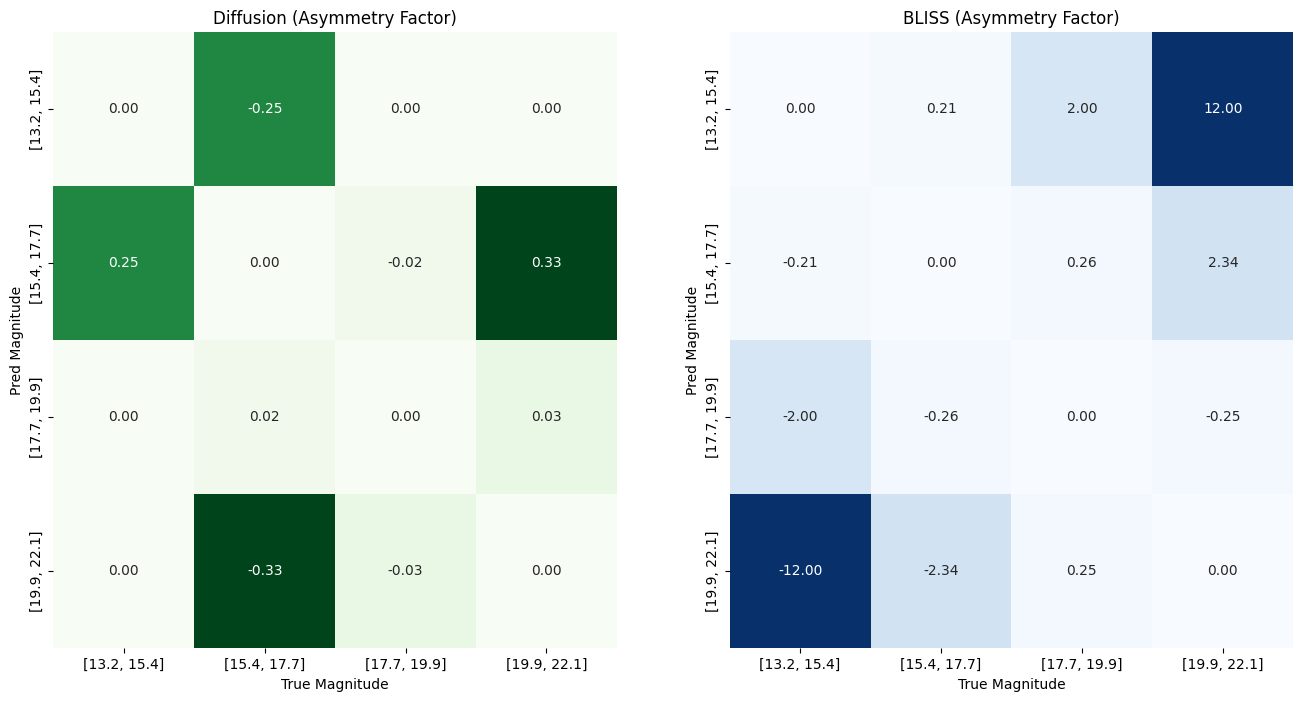

In [26]:
d_pred_m = convert_flux_to_magnitude(diffusion_pred_fluxes, zero_point=1e9)
d_true_m = convert_flux_to_magnitude(diffusion_true_fluxes, zero_point=1e9)
b_pred_m = convert_flux_to_magnitude(bliss_pred_fluxes, zero_point=1e9)
b_true_m = convert_flux_to_magnitude(bliss_true_fluxes, zero_point=1e9)

min_m = max(d_true_m.min().item(), b_true_m.min().item()) + 0.5
max_m = min(d_true_m.max().item(), b_true_m.max().item()) - 0.5

bin_b_num = 5
bin_boundaries = torch.linspace(min_m, max_m, bin_b_num)
bins = list(zip(bin_boundaries[:-1], bin_boundaries[1:]))
d_pred_m_bin_indexes = torch.bucketize(d_pred_m, bin_boundaries)
d_true_m_bin_indexes = torch.bucketize(d_true_m, bin_boundaries)
b_pred_m_bin_indexes = torch.bucketize(b_pred_m, bin_boundaries)
b_true_m_bin_indexes = torch.bucketize(b_true_m, bin_boundaries)

d_cm = torch.zeros(bin_b_num + 1, bin_b_num + 1, dtype=torch.int)
for ri in range(d_cm.shape[0]):
    for ci in range(d_cm.shape[1]):
        d_cm[ri, ci] = ((d_pred_m_bin_indexes == ri) & (d_true_m_bin_indexes == ci)).sum()
d_cm = d_cm[1:-1, 1:-1]

b_cm = torch.zeros(bin_b_num + 1, bin_b_num + 1, dtype=torch.int)
for ri in range(b_cm.shape[0]):
    for ci in range(b_cm.shape[1]):
        b_cm[ri, ci] = ((b_pred_m_bin_indexes == ri) & (b_true_m_bin_indexes == ci)).sum()
b_cm = b_cm[1:-1, 1:-1]

bin_labels = [f"[{lb.item():.1f}, {rb.item():.1f}]" for lb, rb in bins]

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.heatmap(d_cm,
            annot=True,
            fmt="d", cmap="Greens", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[0])
axes[0].set_xlabel("True Magnitude")
axes[0].set_ylabel("Pred Magnitude")
axes[0].set_title("Diffusion")
sns.heatmap(b_cm,
            annot=True,
            fmt="d", cmap="Blues", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[1])
axes[1].set_xlabel("True Magnitude")
axes[1].set_ylabel("Pred Magnitude")
axes[1].set_title("BLISS")
fig.show()

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.heatmap(d_cm / torch.sum(d_cm, dim=0, keepdim=True),
            annot=True,
            fmt=".2f", cmap="Greens", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[0])
axes[0].set_xlabel("True Magnitude")
axes[0].set_ylabel("Pred Magnitude")
axes[0].set_title("Diffusion (CM in Percent)")
sns.heatmap(b_cm / torch.sum(b_cm, dim=0, keepdim=True),
            annot=True,
            fmt=".2f", cmap="Blues", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[1])
axes[1].set_xlabel("True Magnitude")
axes[1].set_ylabel("Pred Magnitude")
axes[1].set_title("BLISS (CM in Percent)")
fig.show()

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.heatmap(((d_cm - d_cm.T) / torch.minimum(d_cm, d_cm.T).clamp(min=1)).abs(),
            annot=(d_cm - d_cm.T) / torch.minimum(d_cm, d_cm.T).clamp(min=1),
            fmt=".2f", cmap="Greens", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[0])
axes[0].set_xlabel("True Magnitude")
axes[0].set_ylabel("Pred Magnitude")
axes[0].set_title("Diffusion (Asymmetry Factor)")
sns.heatmap(((b_cm - b_cm.T) / torch.minimum(b_cm, b_cm.T).clamp(min=1)).abs(),
            annot=(b_cm - b_cm.T) / torch.minimum(b_cm, b_cm.T).clamp(min=1),
            fmt=".2f", cmap="Blues", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=axes[1])
axes[1].set_xlabel("True Magnitude")
axes[1].set_ylabel("Pred Magnitude")
axes[1].set_title("BLISS (Asymmetry Factor)")
fig.show()